# Liberty Mutual Insurance: Property Inspection Prediction 

## Importing packages

In [2]:
import pandas as pd
import os
import numpy as np
import xgboost as xgb
import operator
from matplotlib import pylab as plt
from sklearn.metrics import r2_score
os.chdir("/Users/priya/Desktop/ML/ML_project_data")

## Reading data

In [3]:
# Importing and reading data
data= pd.read_csv("train.csv")
data.head()

,Id,Hazard,T1_V1,T1_V2,T1_V3,T1_V4,T1_V5,T1_V6,T1_V7,T1_V8,...,T2_V6,T2_V7,T2_V8,T2_V9,T2_V10,T2_V11,T2_V12,T2_V13,T2_V14,T2_V15
0,1,1,15,3,2,N,B,N,B,B,...,2,37,1,11,6,Y,N,E,2,2
1,2,4,16,14,5,H,B,N,B,B,...,2,22,1,18,5,Y,Y,E,2,1
2,3,1,10,10,5,N,K,N,B,B,...,6,37,2,14,6,Y,Y,E,6,1
3,4,1,18,18,5,N,K,N,B,B,...,2,25,1,1,6,Y,N,C,2,6
4,5,1,13,19,5,N,H,N,B,B,...,1,22,1,2,7,N,N,E,1,1


## Data Pre-processing

### Checking null values

In [4]:
# Checking null values
data.isnull().values.any()

False

In [16]:
print(data.Hazard.unique())

[ 1  4  5  7 15 14  8 16  6 11  3 13  2 18 10 17 22  9 21 20 12 19 37 23
 28 27 31 38 41 26 33 29 30 25 24 36 51 42 34 46 32 69 40 35 44 39 49 52
 63 64]


### Converting categorical variables to numbers

In [5]:
data1=data.loc[:, data.columns != 'Hazard']
def ceate_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1

    outfile.close()
#  Converting categorical values to numbers by grouping the mean values of Hazard score
def get_data():
    features = list(data1.columns)
    y = data.Hazard

    for feat in data.select_dtypes(include=['object']).columns:
        m = data.groupby([feat])['Hazard'].mean()
        data[feat].replace(m,inplace=True)

    x = data[features]
    return features, x, y
features, x, y = get_data()
ceate_feature_map(features)

### Xgboost Feature Importance

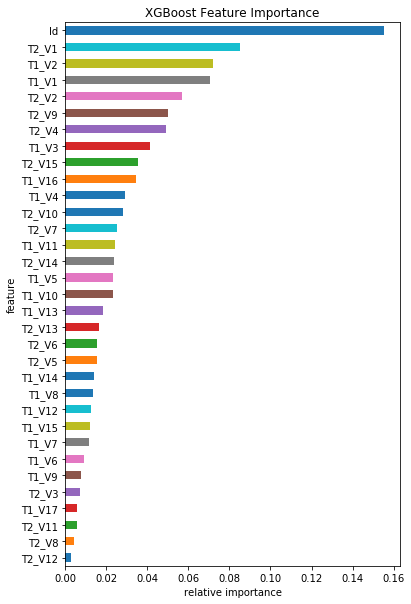

In [17]:
# Xgboost feature importance
xgb_params = {"objective": "reg:linear", "eta": 0.01, "max_depth": 8, "seed": 42, "silent": 1}
num_rounds = 1000

dtrain = xgb.DMatrix(x, label=y)
gbdt = xgb.train(xgb_params, dtrain, num_rounds)

importance = gbdt.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.gcf().savefig('feature_importance_xgb.png')

## Train Test split

In [6]:
# Splitting into train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(x,y,test_size=0.4, random_state=42)

## Building Models

### Parametric models

#### Multivariate Linear Regression

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_linreg_pred= linreg.predict(X_test)
r2_linreg= r2_score(y_test, y_linreg_pred)
print('Linear Regression R squared:',r2_linreg)
print(mean_squared_error(y_test, y_linreg_pred))

Linear Regression R squared: 0.08999208370936052
15.15137737313383


#### Ridge Regression

In [9]:
# Ridge regression model
from sklearn import linear_model
ridge = linear_model.Ridge(alpha=0.05)
ridge.fit(X_train, y_train)
y_ridge_pred= ridge.predict(X_test)
r2_ridge= r2_score(y_test, y_ridge_pred)
print('Ridge R squared:',r2_ridge)
print('Mean Squared error:',mean_squared_error(y_test, y_ridge_pred))
# np.linspace(1e-7, 1)

Ridge R squared: 0.08998497878360112
Mean Squared error: 15.151495668161227


#### Lasso Regression

In [10]:
# Lasso regression model
from sklearn import linear_model
lasso = linear_model.Lasso(alpha=0.006188497,  copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
lasso.fit(X_train, y_train)
y_lasso_pred= lasso.predict(X_test)
r2_lasso= r2_score(y_test, y_lasso_pred)
print('Lasso R squared:',r2_lasso)
print('Mean Squared error:',mean_squared_error(y_test, y_lasso_pred))
# 0.006188497

Lasso R squared: 0.08926758519686062
Mean Squared error: 15.163440070801235


### Non-parametric model

#### Random forest

In [11]:
# Random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import precision_recall_fscore_support
forest = RandomForestRegressor(n_estimators = 500, n_jobs=-1, max_depth=400, oob_score=False, max_features=11)
forest.fit(X_train, y_train)
y_rf_pred= forest.predict(X_test)
r2_rf= r2_score(y_test, y_rf_pred)
print('Randon_forest R squared:', r2_rf)
print('Mean Squared error:',mean_squared_error(y_test, y_rf_pred))

Randon_forest R squared: 0.09668263266120869
Mean Squared error: 15.03998160372549


In [12]:
d = {'Pred_values': y_rf_pred[0:10], 'Actual_values': y_test[0:10]}
df = pd.DataFrame(data=d)
df

,Actual_values,Pred_values
4207,1,4.488
6583,6,4.938
21013,5,4.566
12773,4,3.682
22264,1,2.936
3918,1,5.112
37967,1,2.304
34514,4,4.894
32435,4,5.038
44815,1,4.198


In [13]:
values= np.array([r2_linreg, r2_ridge, r2_lasso, r2_rf])
s= pd.Series(values, ['Linear_regression', 'Ridge','Lasso','Random_forest'])
print(s)

Linear_regression    0.089992
Ridge                0.089985
Lasso                0.089268
Random_forest        0.096683
dtype: float64


## R squared values plot

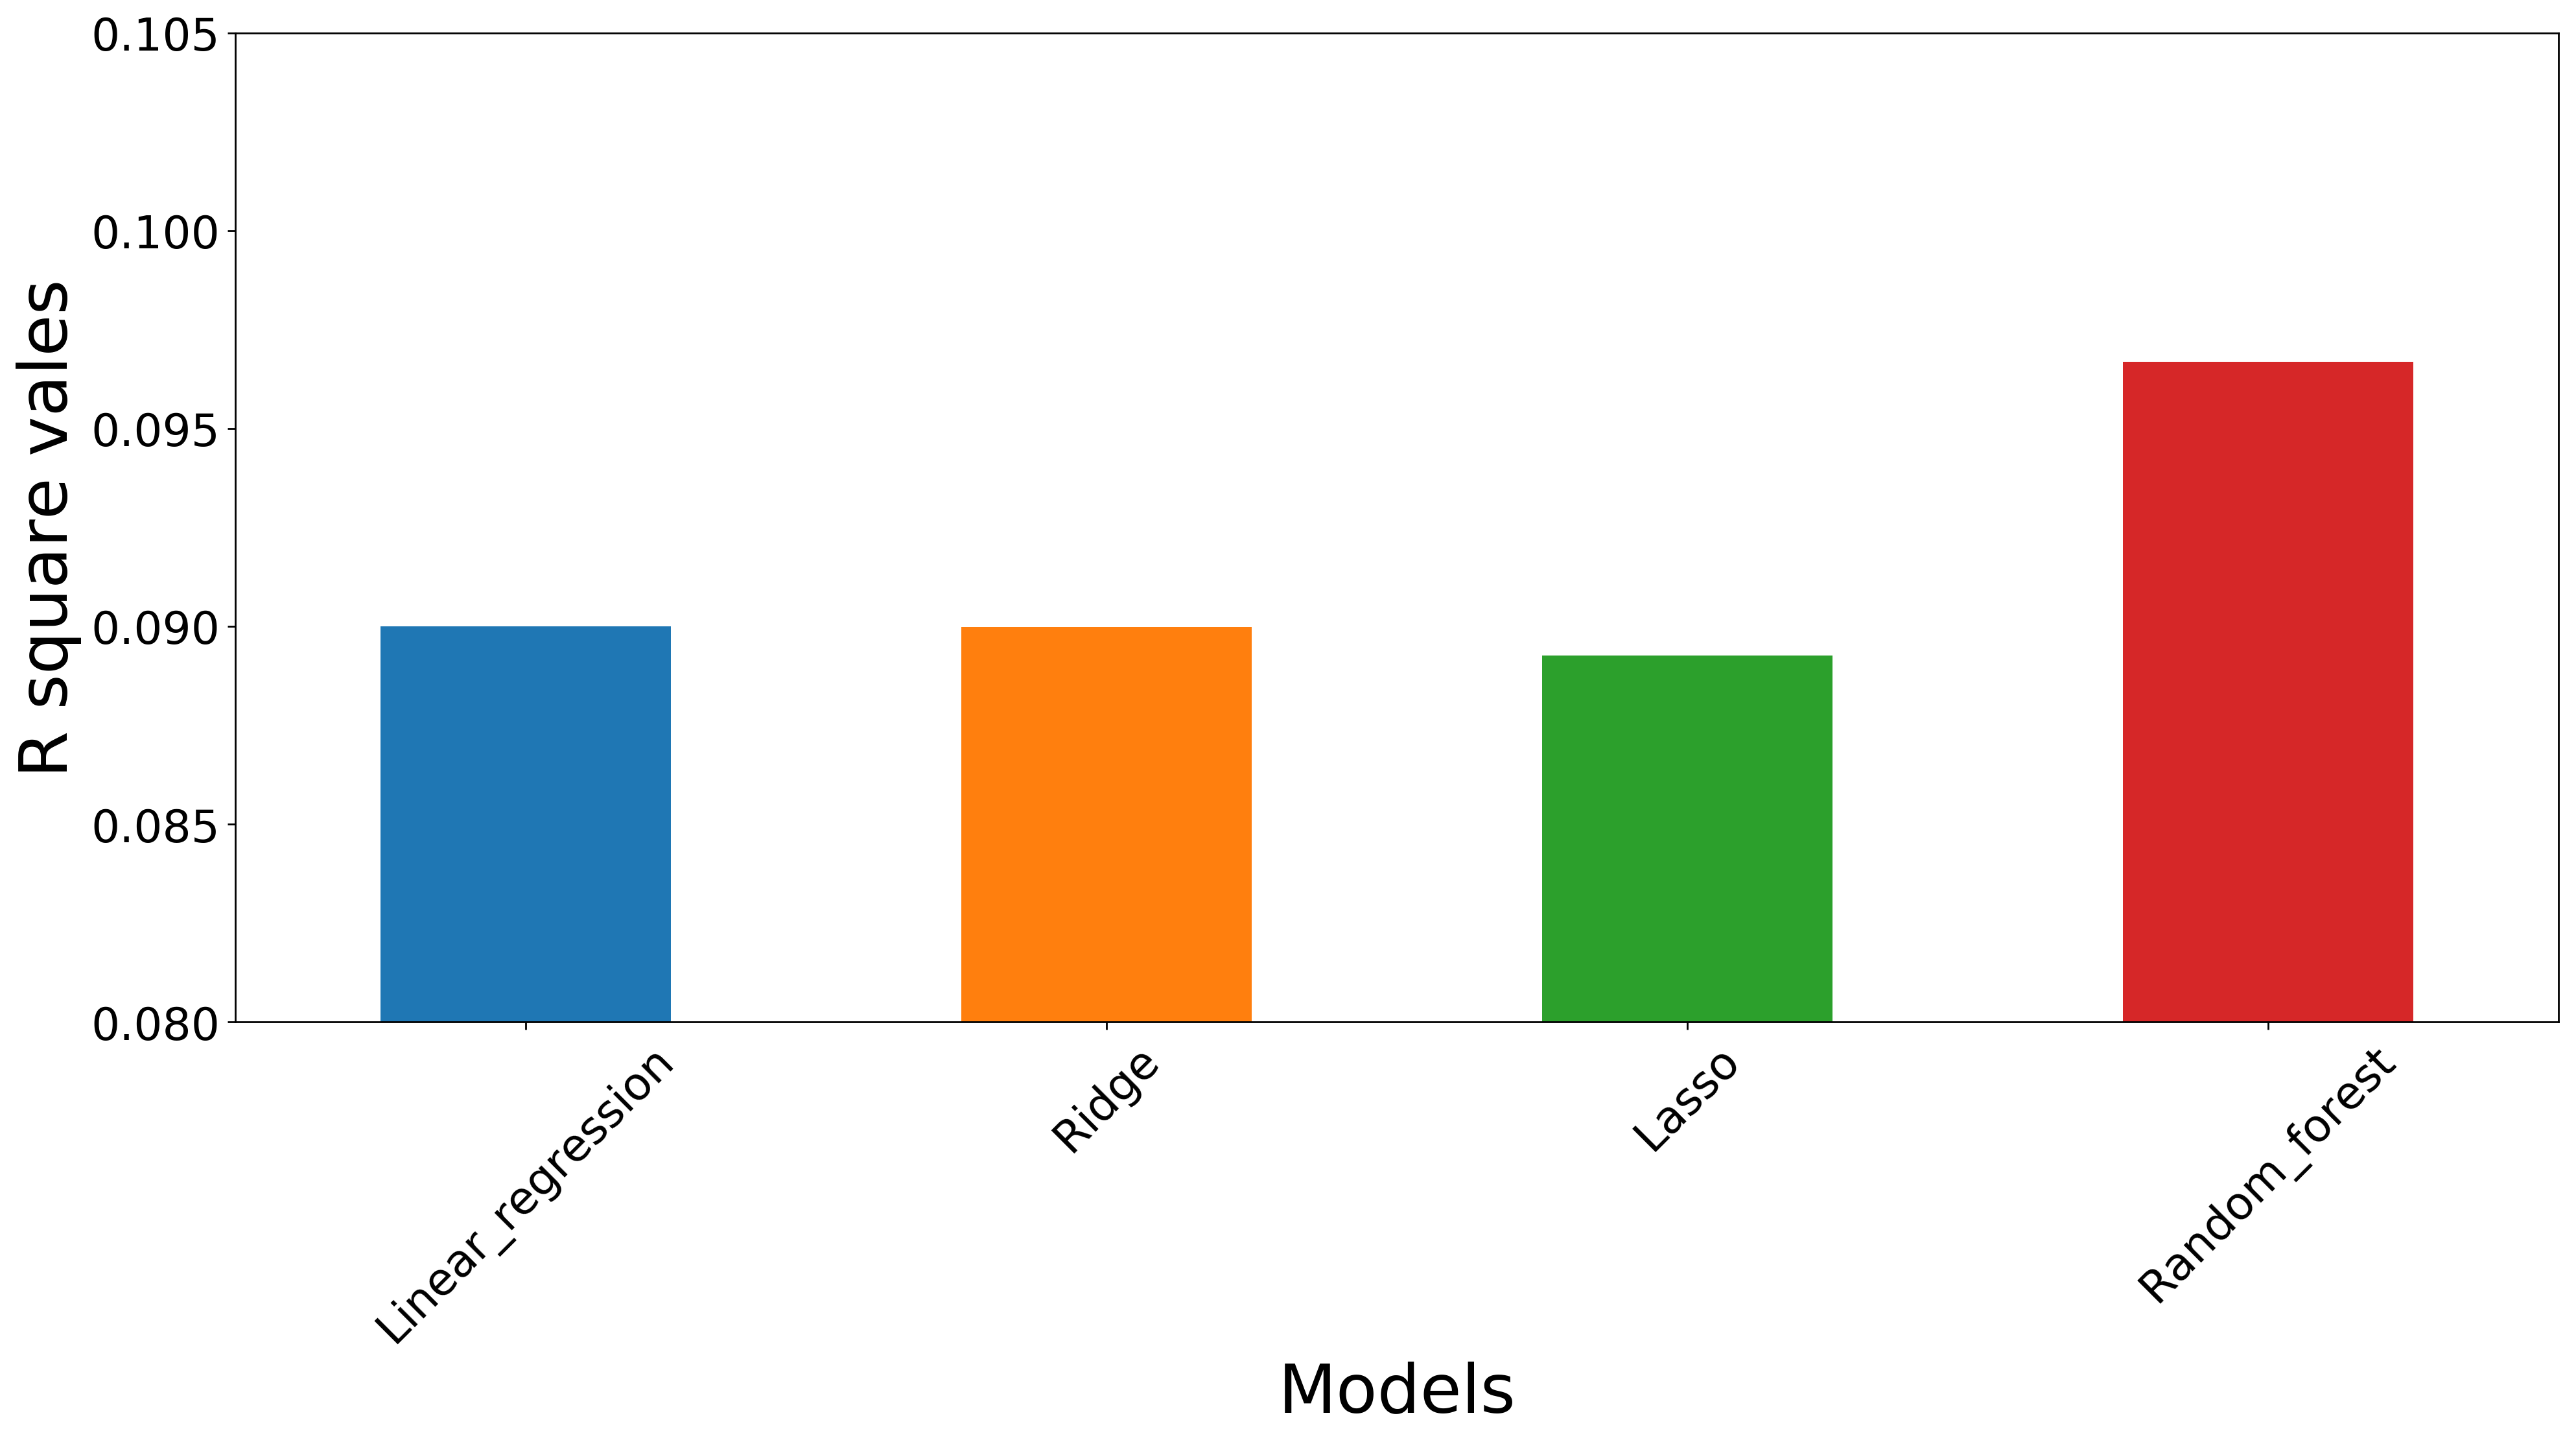

In [14]:
plt.figure(figsize=(16,9),dpi=250)
s.plot.bar(fontsize=20, rot=45)
plt.xlabel('Models', fontsize=30)
plt.ylim(0.08,0.105)
plt.ylabel('R square vales', fontsize=30)

plt.tight_layout()
plt.show()